In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_parquet('./data/blocks.parquet')[['geometry', 'land_use', 'fsi', 'gsi', 'mxi']]
blocks_gdf.head()

,geometry,land_use,fsi,gsi,mxi
id,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,0.054497,0.017345,0.700000
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",transport,0.444238,0.217986,0.211541
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",recreation,0.003234,0.003205,0.700000
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",residential,0.235746,0.056437,0.660753
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",recreation,0.086291,0.025381,0.692085


## Generating adjacency graph

In [2]:
from blocksnet.relations import generate_adjacency_graph

graph = generate_adjacency_graph(blocks_gdf, 1)
len(graph.edges)

2025-02-28 01:02:29.369 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:7 - Generating nodes.
2025-02-28 01:02:29.514 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:12 - Generating edges.
2025-02-28 01:02:30.722 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:31 - Adjacency graph successfully generated: 16320 nodes, 15926 edges


15926

## Generating features

In [37]:
from blocksnet.machine_learning.feature_engineering import generate_geometry_features

features_gdf = generate_geometry_features(blocks_gdf, False, False)

2025-02-28 01:06:31.039 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_usual_features:33 - Calculating usual features.
2025-02-28 01:06:31.248 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_radiuses:42 - Calculating radiuses.
100%|██████████| 16320/16320 [00:17<00:00, 910.40it/s] 
2025-02-28 01:06:55.432 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_aspect_ratios:54 - Calculating radiuses.
100%|██████████| 16320/16320 [00:00<00:00, 33168.76it/s]


In [39]:
features_gdf = features_gdf.drop(columns=['geometry'])

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_gdf.iloc[:, :] = scaler.fit_transform(features_gdf)
features_gdf.head()

/tmp/ipykernel_189682/1363931813.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3.90337756  0.63083426  1.53271627 ...  0.73390649 -0.4256561
 -0.50296027]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  features_gdf.iloc[:, :] = scaler.fit_transform(features_gdf)


,area,length,corners_count,outer_radius,inner_radius,aspect_ratio
id,,,,,,
0,1.956782,3.565802,3.903378,3.039974,2.999685,-0.319620
1,-0.163345,0.198848,0.630834,0.303067,-0.367928,0.308300
2,0.758829,1.200566,1.532716,0.849605,1.710123,-0.369853
3,0.306765,1.091746,1.249268,1.183128,0.264279,-0.299391
4,4.608753,3.345316,3.284944,3.252816,5.601732,-0.334876


## GNN

In [41]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

import torch.nn.functional as F

### Data

In [42]:
import pandas as pd

dummies_df = pd.get_dummies(blocks_gdf['land_use']).replace({False:0, True:1})
dummies_df.head()

/tmp/ipykernel_189682/2852187691.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dummies_df = pd.get_dummies(blocks_gdf['land_use']).replace({False:0, True:1})


,agriculture,business,industrial,recreation,residential,special,transport
id,,,,,,,
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0


In [ ]:
features_gdf = features_gdf.join(dummies_df)
features_gdf.head()

,area,length,corners_count,outer_radius,inner_radius,aspect_ratio,agriculture,business,industrial,recreation,residential,special,transport
id,,,,,,,,,,,,,
0,1.956782,3.565802,3.903378,3.039974,2.999685,-0.319620,0,0,0,0,0,0,0
1,-0.163345,0.198848,0.630834,0.303067,-0.367928,0.308300,0,0,0,0,0,0,1
2,0.758829,1.200566,1.532716,0.849605,1.710123,-0.369853,0,0,0,1,0,0,0
3,0.306765,1.091746,1.249268,1.183128,0.264279,-0.299391,0,0,0,0,1,0,0
4,4.608753,3.345316,3.284944,3.252816,5.601732,-0.334876,0,0,0,1,0,0,0


In [44]:
x = torch.tensor(features_gdf.values, dtype=torch.float)
x

tensor([[ 1.9568,  3.5658,  3.9034,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1633,  0.1988,  0.6308,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.7588,  1.2006,  1.5327,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1764,  2.1834,  0.7339,  ...,  0.0000,  0.0000,  1.0000],
        [-0.2219, -0.1264, -0.4257,  ...,  0.0000,  0.0000,  1.0000],
        [ 2.6744,  2.2403, -0.5030,  ...,  0.0000,  1.0000,  0.0000]])

In [45]:
y = torch.tensor(blocks_gdf[['fsi', 'gsi', 'mxi']].fillna(0).values, dtype=torch.float)
y

tensor([[0.0545, 0.0173, 0.7000],
        [0.4442, 0.2180, 0.2115],
        [0.0032, 0.0032, 0.7000],
        ...,
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.1014, 0.0612, 0.3631]])

In [46]:
edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
edge_index

tensor([[    0,     1,     1,  ..., 16303, 16303, 16306],
        [  419,  1060,  1426,  ..., 16309, 16310, 16307]])

In [47]:
data = Data(x=x, edge_index=edge_index, y=y)
data

Data(x=[16320, 13], edge_index=[2, 15926], y=[16320, 3])

In [48]:
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
    range(len(y)),
    train_size=0.8
)

# Создаем маски для обучающих и тестовых данных
train_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)

train_mask[train_indices] = True
test_mask[test_indices] = True

In [49]:
NUM_FEATURES = x.shape[1]
NUM_CLASSES = y.shape[1]
NUM_FEATURES, NUM_CLASSES

(13, 3)

### Model

In [73]:
from torch_geometric.nn import GCNConv, SAGEConv

class GNN(torch.nn.Module):
    def __init__(self, num_features : int, num_classes : int):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(num_features, 8)
        self.conv2 = SAGEConv(8, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Применяем разные функции активации для разных выходов
        gsi = torch.sigmoid(x[:, 1])
        mxi = torch.sigmoid(x[:, 2])
        fsi = torch.relu(x[:, 0]) + gsi
        return torch.stack([fsi, gsi, mxi], dim=1)

### Train

In [ ]:
model = GNN(NUM_FEATURES, NUM_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)

losses = []
model.train()
for epoch in range(100_000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out[train_mask], data.y[train_mask])
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

Epoch 0, Loss 0.2445194572210312
Epoch 100, Loss 0.18719860911369324
Epoch 200, Loss 0.16052615642547607
Epoch 300, Loss 0.13893991708755493
Epoch 400, Loss 0.12396840751171112
Epoch 500, Loss 0.11421587318181992
Epoch 600, Loss 0.10739061236381531
Epoch 700, Loss 0.10174334049224854
Epoch 800, Loss 0.09642866253852844
Epoch 900, Loss 0.09237070381641388
Epoch 1000, Loss 0.089235320687294
Epoch 1100, Loss 0.08666287362575531
Epoch 1200, Loss 0.08448363095521927
Epoch 1300, Loss 0.08261232823133469
Epoch 1400, Loss 0.08099816739559174
Epoch 1500, Loss 0.07960972189903259
Epoch 1600, Loss 0.07843484729528427
Epoch 1700, Loss 0.07745072990655899
Epoch 1800, Loss 0.07663261890411377
Epoch 1900, Loss 0.07594335824251175
Epoch 2000, Loss 0.07535228878259659
Epoch 2100, Loss 0.07483848929405212
Epoch 2200, Loss 0.07438714802265167
Epoch 2300, Loss 0.07398383319377899
Epoch 2400, Loss 0.07362046837806702
Epoch 2500, Loss 0.07328806817531586
Epoch 2600, Loss 0.07297948747873306
Epoch 2700, Loss

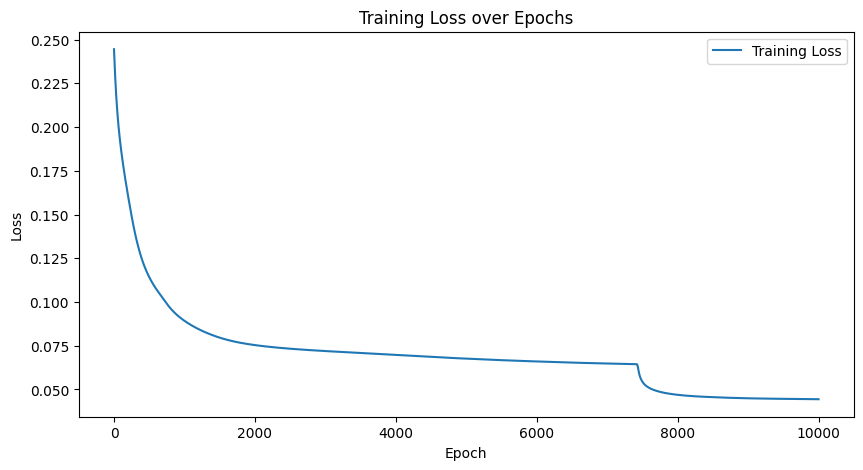

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses[0:], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

In [76]:
model.eval()
out = model(data)
loss = F.mse_loss(out[test_mask], data.y[test_mask])
print(f'Test loss: {loss.item()}')

Test loss: 0.05023718252778053


In [78]:
blocks_gdf[['fsi_pred', 'gsi_pred', 'mxi_pred']] = out.detach().numpy()
blocks_gdf.head()

,geometry,land_use,fsi,gsi,mxi,fsi_pred,gsi_pred,mxi_pred
id,,,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,0.054497,0.017345,0.700000,0.057776,0.057776,0.240915
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",transport,0.444238,0.217986,0.211541,0.032041,0.032041,0.016150
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",recreation,0.003234,0.003205,0.700000,0.114181,0.114181,0.204026
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",residential,0.235746,0.056437,0.660753,0.600599,0.211782,0.420186
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",recreation,0.086291,0.025381,0.692085,0.041028,0.041028,0.226361


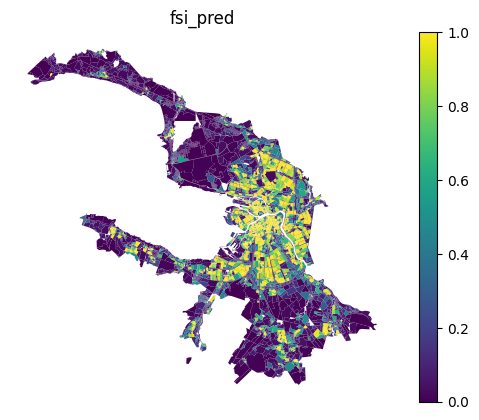

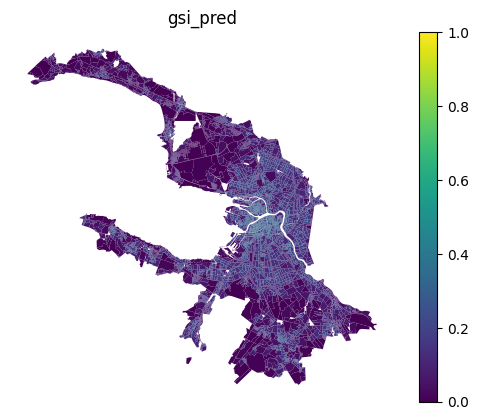

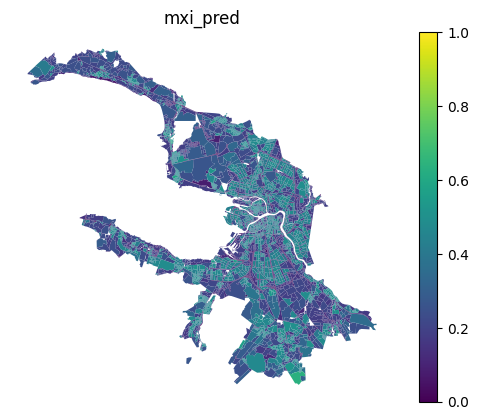

In [81]:
for column in ['fsi_pred', 'gsi_pred', 'mxi_pred']:
    ax = blocks_gdf.plot(column, legend=True, vmin=0, vmax=1)
    ax.set_title(column)
    ax.set_axis_off()

In [80]:
import numpy as np

# Функция для оценки важности признаков
def feature_importance(model, data, num_features):
    model.eval()
    importance = np.zeros(num_features)
    for i in range(num_features):
        original_feature = data.x[:, i].clone()
        data.x[:, i] = 0
        out = model(data)
        loss = F.mse_loss(out, data.y)
        importance[i] = loss.item()
        data.x[:, i] = original_feature
    return importance

# Оценка важности признаков
importance = feature_importance(model, data, NUM_FEATURES)

for col in features_gdf.columns:
    print(f'{col}: {importance[features_gdf.columns.get_loc(col)]}')

area: 0.04662435129284859
length: 0.05531020835042
corners_count: 0.08309509605169296
outer_radius: 0.05037819966673851
inner_radius: 0.055494748055934906
aspect_ratio: 0.04798201844096184
agriculture: 0.04565759375691414
business: 0.046307239681482315
industrial: 0.04587529972195625
recreation: 0.047266893088817596
residential: 0.06952004879713058
special: 0.04558700695633888
transport: 0.047431062906980515


## Vologda check

In [85]:
blocks_gdf = gpd.read_parquet('./../tests/data/_blocks.parquet')

In [89]:
from blocksnet.relations import generate_adjacency_graph

graph = generate_adjacency_graph(blocks_gdf, 1)
len(graph.edges)

2025-02-28 01:20:40.863 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:7 - Generating nodes.
2025-02-28 01:20:40.864 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:12 - Generating edges.
2025-02-28 01:20:40.927 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:31 - Adjacency graph successfully generated: 737 nodes, 719 edges


719

In [90]:
from blocksnet.machine_learning.feature_engineering import generate_geometry_features

features_gdf = generate_geometry_features(blocks_gdf, False, False)

2025-02-28 01:20:42.530 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_usual_features:33 - Calculating usual features.
2025-02-28 01:20:42.544 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_radiuses:42 - Calculating radiuses.
100%|██████████| 737/737 [00:01<00:00, 665.74it/s]
2025-02-28 01:20:44.057 | INFO     | blocksnet.machine_learning.feature_engineering.core:_calculate_aspect_ratios:54 - Calculating radiuses.
100%|██████████| 737/737 [00:00<00:00, 24242.06it/s]


In [91]:
features_gdf = features_gdf.drop(columns=['geometry'])

In [92]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_gdf.iloc[:, :] = scaler.fit_transform(features_gdf)
features_gdf.head()

/tmp/ipykernel_189682/1363931813.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-5.73421489e-01 -5.31134954e-01  4.60667913e+00 -6.59830611e-02
 -2.13985936e-01  1.35061588e+00 -4.88848418e-01 -5.52278222e-01
 -5.09991686e-01 -4.46561882e-01  6.74031313e-01 -5.94564757e-01
 -4.25418614e-01 -1.29412865e-01 -5.31134954e-01 -5.94564757e-01
 -6.57994561e-01  8.20198138e-02 -5.94564757e-01 -1.92842668e-01
  6.08765459e-02 -4.67705150e-01 -4.04275347e-01  6.31744778e-01
  1.85900103e-02  2.30022689e-01  2.30022689e-01 -6.79137829e-01
 -5.52278222e-01  1.85900103e-02  2.08879421e-01 -6.15708025e-01
  2.04834372e+00  9.06607260e-01 -6.59830611e-02  2.34434947e+00
  1.45449617e-01  1.39290242e+00 -1.08269597e-01  1.13918321e+00
  1.02096451e+01 -2.36965254e-02 -5.09991686e-01 -3.83132079e-01
  1.07575340e+00  1.18146974e+00 -2.56272472e-01 -4.46561882e-01
 -3.19702275e-01 -6.15708025e-01 -2.77415740e-01  3.14595760e-0

,area,length,corners_count,outer_radius,inner_radius,aspect_ratio
0,-0.238319,-0.559115,-0.573421,-0.583934,-0.664564,-0.088056
1,-0.234584,-0.454065,-0.531135,-0.453227,-0.671715,0.054267
2,7.649491,5.833159,4.606679,5.051103,2.038318,-0.135825
3,0.028516,0.592002,-0.065983,0.598706,1.161223,-0.146080
4,-0.176716,-0.137339,-0.213986,-0.120367,-0.225058,-0.062333


In [95]:
import pandas as pd

dummies_df = pd.DataFrame(0, index=blocks_gdf.index, columns=[str(i) for i in range(0,7)])
dummies_df.head()

,0,1,2,3,4,5,6
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [96]:
features_gdf = features_gdf.join(dummies_df)
features_gdf.head()

,area,length,corners_count,outer_radius,inner_radius,aspect_ratio,0,1,2,3,4,5,6
0,-0.238319,-0.559115,-0.573421,-0.583934,-0.664564,-0.088056,0,0,0,0,0,0,0
1,-0.234584,-0.454065,-0.531135,-0.453227,-0.671715,0.054267,0,0,0,0,0,0,0
2,7.649491,5.833159,4.606679,5.051103,2.038318,-0.135825,0,0,0,0,0,0,0
3,0.028516,0.592002,-0.065983,0.598706,1.161223,-0.146080,0,0,0,0,0,0,0
4,-0.176716,-0.137339,-0.213986,-0.120367,-0.225058,-0.062333,0,0,0,0,0,0,0


In [97]:
x = torch.tensor(features_gdf.values, dtype=torch.float)
x

tensor([[-0.2383, -0.5591, -0.5734,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2346, -0.4541, -0.5311,  ...,  0.0000,  0.0000,  0.0000],
        [ 7.6495,  5.8332,  4.6067,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0293,  3.3876,  1.0546,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0602,  3.5435,  1.0335,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2349, -0.2820, -0.5734,  ...,  0.0000,  0.0000,  0.0000]])

In [99]:
edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
edge_index

tensor([[  0,   0,   1,  ..., 721, 723, 735],
        [257, 355,  15,  ..., 734, 736, 736]])

In [100]:
data = Data(x=x, edge_index=edge_index)
data

Data(x=[737, 13], edge_index=[2, 719])

In [101]:
model.eval()
out = model(data)

In [102]:
blocks_gdf[['fsi_pred', 'gsi_pred', 'mxi_pred']] = out.detach().numpy()
blocks_gdf.head()

,geometry,zone,land_use,fsi_pred,gsi_pred,mxi_pred
0,"POLYGON ((550762.290 6565038.844, 550768.857 6...",zone_1,RECREATION,0.029502,0.029502,0.033607
1,"POLYGON ((550768.857 6565033.563, 550762.290 6...",zone_1,RECREATION,0.023948,0.023948,0.028850
2,"POLYGON ((544937.479 6564706.592, 544935.619 6...",zone_1,RECREATION,0.039173,0.039173,0.248234
3,"POLYGON ((544806.647 6565359.291, 544814.358 6...",zone_1,RECREATION,0.083133,0.083133,0.259173
4,"POLYGON ((544793.346 6565395.228, 544800.150 6...",zone_1,RECREATION,0.079063,0.079063,0.101449


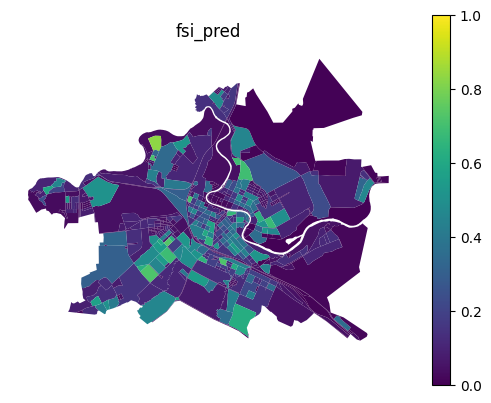

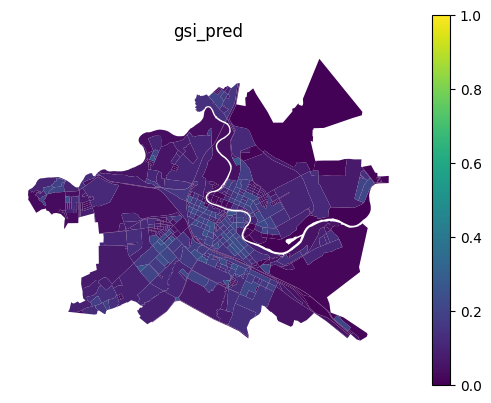

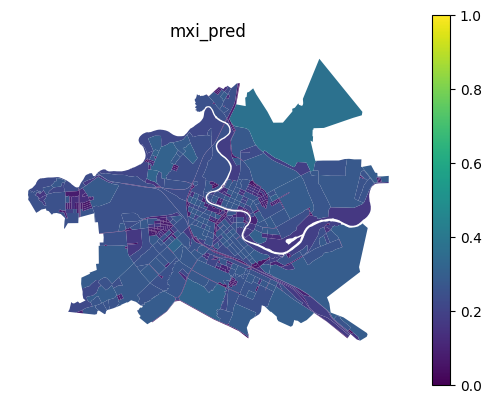

In [103]:
for column in ['fsi_pred', 'gsi_pred', 'mxi_pred']:
    ax = blocks_gdf.plot(column, legend=True, vmin=0, vmax=1)
    ax.set_title(column)
    ax.set_axis_off()